### Machine Learning and Contect Analytics

MSc in Business Analytics

Department of Managment Science & Technology

Athens University of Economics and Business

#### Authors
* Alvanou Marianna, ΑΜ: p2822201
* Vlachakis Sotirios, ΑΜ: p2822228

# Model 3 ~ Sequential Model

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#pip install openpyxl

In [3]:
raw_data = pd.read_excel("C:\\Users\\mario\\Downloads\\data_cleaning.xlsx", usecols = ['Brand', 'Comments', 'NPS_Label'])
data = raw_data.sample(frac = 1)
data.head(20)

,Brand,Comments,NPS_Label
7955,10,αμεση εξυπηρετηση,Positive
9313,1,η γραμμή δεν λειτουργει (μονο εξερχομενες κλησ...,Negative
1112,7,"η υποστηριξη με την Vodafone απευθειασ, ηταν ο...",Neutral
13673,10,απλα τοπ,Positive
11494,10,καλη εξυπηρετηση κ η κοπελα ευγενικη...,Positive
5821,9,εξυπηρετηση καλη κι επικοινωνια,Positive
10139,7,η εξυπηρετηση,Neutral
13934,10,μεχρι τωρα εδω και αρκετα χρονια οποτε εχω επι...,Positive
9091,10,ρerfect,Positive
5406,0,παρα πολυ μεγαλη αναμονη και στο τελοσ επεσε η...,Negative


In [4]:
def nps_new(nps):
        if nps == 'Positive':
            return 0
        elif nps == 'Neutral':
            return 1
        else:
            return 2

In [5]:
data['NPS_encoded'] = data['NPS_Label'].apply(nps_new)

In [6]:
reviews = data.Comments
labels = data.NPS_encoded

In [7]:
split_size = int(len(reviews)*0.8)
training_reviews = reviews[:split_size]
testing_reviews = reviews[split_size:]
training_labels = labels[:split_size]
testing_labels = labels[split_size:]

In [8]:
import numpy as np
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(training_labels),
                                                 y=training_labels)
class_weights

array([0.43377652, 3.3114254 , 2.54659842])

In [9]:
vocab_size = 15000
max_length = 120

tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(training_reviews)

training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences, maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(testing_reviews)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
encoded_training_labels = label_encoder.fit_transform(training_labels)
encoded_test_labels = label_encoder.fit_transform(testing_labels)

training_labels_onehot = to_categorical(encoded_training_labels, num_classes=3)
testing_labels_onehot = to_categorical(encoded_test_labels, num_classes=3)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

num_classes = 3

#checkpoint
checkpoint= ModelCheckpoint(filepath='C:\\Users\\mario\\Downloads\\keras_model.h5',
                             mode='max',monitor='val_accuracy',verbose=2,save_best_only=True)


model = tf.keras.models.Sequential([tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(num_classes, activation='softmax'),
                                    ])

model.compile(loss='categorical_crossentropy',
             optimizer=tf.optimizers.Adam(),
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           240000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 512)               983552    
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 1225091 (4.67 MB)
Trainable params: 1225091 (4.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
import tensorflow as tf

# Create an EarlyStopping callback - if it doesn't improve for 2 consecutive epochs, the training will stop early.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

# Use the callbacks during model training
callbacks = [early_stopping, checkpoint]

history = model.fit(training_padded, training_labels_onehot, epochs=10, 
                    validation_data=(testing_padded, testing_labels_onehot),
                    callbacks=callbacks, 
                    class_weight={0: 0.43410768, 1: 3.25190632, 2: 2.57127476}
                    )

Epoch 1/10
373/374 [============================>.] - ETA: 0s - loss: 0.8963 - accuracy: 0.6658
Epoch 1: val_accuracy improved from -inf to 0.69591, saving model to C:\Users\mario\Downloads\keras_model.h5
374/374 [==============================] - 10s 25ms/step - loss: 0.8961 - accuracy: 0.6659 - val_loss: 0.7605 - val_accuracy: 0.6959
Epoch 2/10
  5/374 [..............................] - ETA: 9s - loss: 0.7705 - accuracy: 0.7375

C:\Users\mario\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


372/374 [============================>.] - ETA: 0s - loss: 0.6575 - accuracy: 0.7397
Epoch 2: val_accuracy improved from 0.69591 to 0.69893, saving model to C:\Users\mario\Downloads\keras_model.h5
374/374 [==============================] - 9s 24ms/step - loss: 0.6575 - accuracy: 0.7396 - val_loss: 0.7175 - val_accuracy: 0.6989
Epoch 3/10
372/374 [============================>.] - ETA: 0s - loss: 0.4567 - accuracy: 0.7881
Epoch 3: val_accuracy improved from 0.69893 to 0.74246, saving model to C:\Users\mario\Downloads\keras_model.h5
374/374 [==============================] - 9s 24ms/step - loss: 0.4568 - accuracy: 0.7883 - val_loss: 0.7197 - val_accuracy: 0.7425
Epoch 4/10
372/374 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.8524
Epoch 4: val_accuracy did not improve from 0.74246
374/374 [==============================] - 9s 24ms/step - loss: 0.3241 - accuracy: 0.8526 - val_loss: 0.9100 - val_accuracy: 0.6470
Epoch 5/10
373/374 [============================>.] 

### Plot Loss and Accuracy

In [13]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(6, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

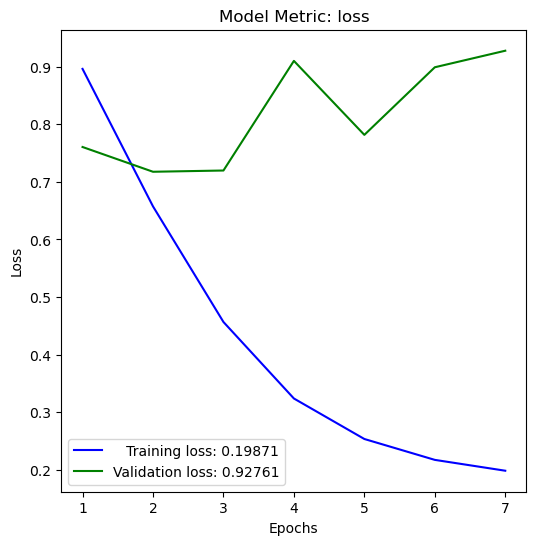

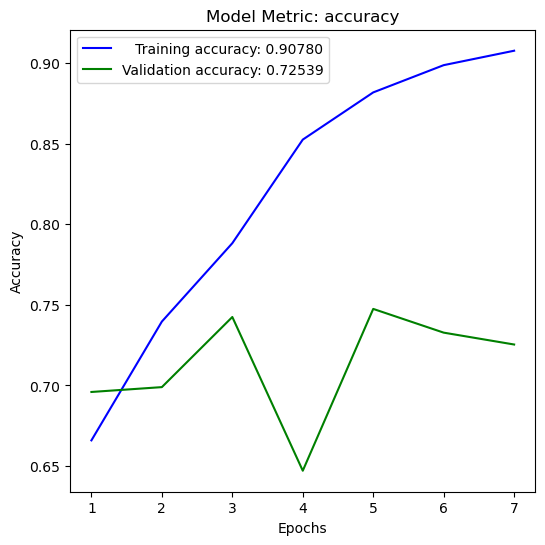

In [14]:
plot_keras_history(history)

In [17]:
import keras
Model_MLP = keras.models.load_model('C:\\Users\\mario\\Downloads\\keras_model.h5') #importing the model from the checkpoint

In [18]:
# saving the model to json format
open('model_keras.json', 'w').write(model.to_json())

1971

In [19]:
# saving the weights of the model separately
model.save_weights('weights_Model3.h5')

### Model Evaluation

In [20]:
Acc = model.evaluate(testing_padded, testing_labels_onehot, verbose=2)

94/94 - 0s - loss: 0.7816 - accuracy: 0.7475 - 372ms/epoch - 4ms/step


In [21]:
print('\nTest categorical_crossentropy: {:.3f} %'.format(Acc[0]*100))
print('\nTest accuracy: {:.3f} %'.format(Acc[1]*100))


Test categorical_crossentropy: 78.158 %

Test accuracy: 74.749 %


### Model Prediction

In [22]:
# Assuming you have new_comments as a list containing the new comments to predict
new_comments = ['όλα τελεια', 'το σημα είναι άθλιο', 'απαραδεκτο προσωπικό', 'προβλημα με το σημα']

# Preprocess the new comments
new_sequences = tokenizer.texts_to_sequences(new_comments)
new_padded = pad_sequences(new_sequences, maxlen=max_length)

# Make predictions with the model
predicted_probabilities = model.predict(new_padded)

# Interpret the predictions
sentiments = ['Positive', 'Neutral', 'Negative']

for i in range(len(new_comments)):
    comment = new_comments[i]
    probabilities = predicted_probabilities[i]
    
    predicted_sentiment = sentiments[probabilities.argmax()]
    predicted_prob = probabilities.max()
    
    print(f"Comment: '{comment}' - Predicted Sentiment: {predicted_sentiment} (Probability: {predicted_prob:.4f})")


1/1 [==============================] - 0s 111ms/step
Comment: 'όλα τελεια' - Predicted Sentiment: Positive (Probability: 0.9588)
Comment: 'το σημα είναι άθλιο' - Predicted Sentiment: Negative (Probability: 0.5879)
Comment: 'απαραδεκτο προσωπικό' - Predicted Sentiment: Negative (Probability: 0.7568)
Comment: 'προβλημα με το σημα' - Predicted Sentiment: Negative (Probability: 0.5598)


### AUC

In [23]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities for each class
y_pred_prob = model.predict(testing_padded)

roc_auc_scores = []
for i in range(num_classes):
    roc_auc = roc_auc_score(testing_labels_onehot[:, i], y_pred_prob[:, i])
    roc_auc_scores.append(roc_auc)
  #  print(f'Class {i} ROC AUC: {roc_auc:.2f}')

average_roc_auc = np.mean(roc_auc_scores)
average_roc_auc

94/94 [==============================] - 0s 4ms/step


0.7529553505150405

94/94 [==============================] - 0s 4ms/step


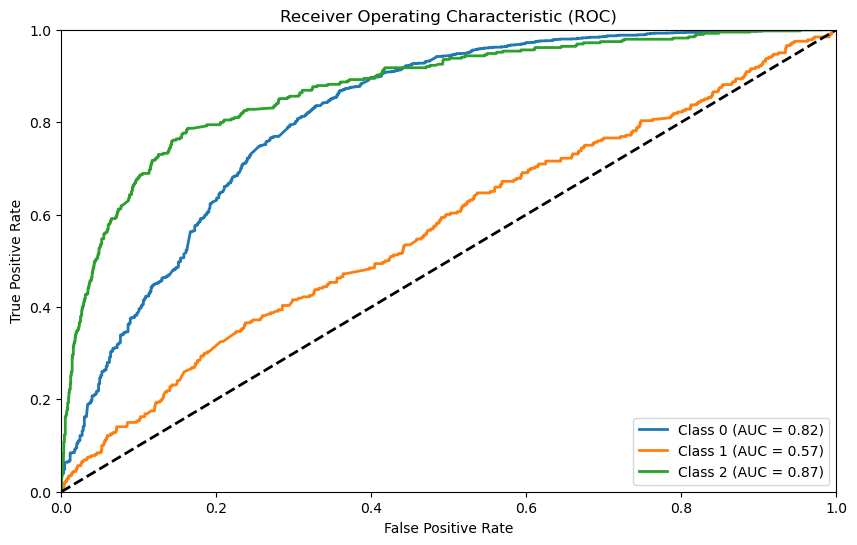

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Get predicted probabilities for each class
y_pred_prob = model.predict(testing_padded)

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(testing_labels_onehot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Confusion Matrix

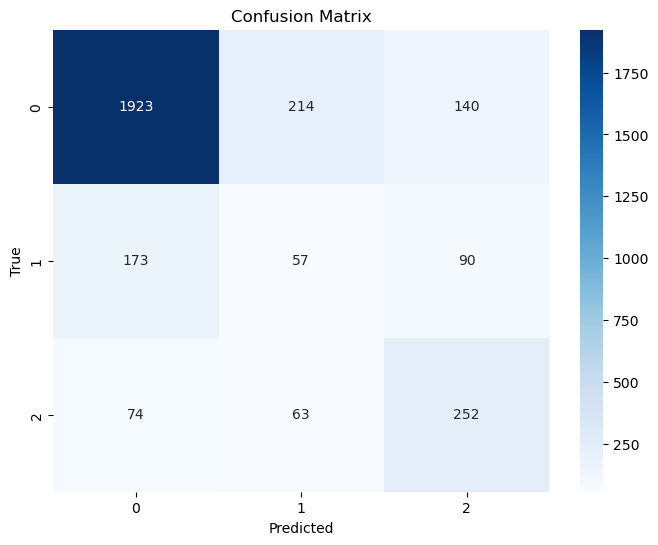

In [25]:
y_pred = np.argmax(y_pred_prob, axis=1)
conf_matrix = confusion_matrix(np.argmax(testing_labels_onehot, axis=1), y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()